In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

#from warpctc_pytorch import CTCLoss

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

ascii           lines           sentences       words           xml
chars.csv       models          synth_words     words.csv       xml.tgz
forms           paragraphs      synth_words.csv words10.csv
line_labels.csv paragraphs.csv  tmp             words_chars.csv


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Synthetic Data

### images

In [70]:
os.makedirs(PATH/'synth_words', exist_ok=True)

In [58]:
def create_img(files, fname):
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), color=(255,255,255))

    y_offset = 0
    for im in imgs:
      new_im.paste(im, (0,y_offset))
      y_offset += im.size[1]

    new_im.save(PATH/'synth_words'/fname)

### labels

In [145]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word'])
df.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


In [125]:
fnames=[]
labels=[]
for i in range(1000):
    res = df.sample(3)
    files = list(map(lambda x: x+'.png', res.filename.values))
    values = res.word.values
    
    fname = '{:03d}'.format(i)+'.png'
    create_img(files, fname)
    fnames.append(fname)
    labels.append(values)
    
synth = pd.DataFrame({'filename': fnames, 'labels': ' '.join(labels)})
synth.head()

,filename,labels,ids
0,000.png,"himself , changes",62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,be Royal from,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,been . 's,56 59 59 68 1 14 1 7 73
3,003.png,in to .,63 68 1 74 69 1 14
4,004.png,the a says,74 62 59 1 55 1 73 55 79 73


# Prelim

### Numericalize characters

In [177]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
len(itos)

81

In [178]:
joined_labels = list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in joined_labels])

In [179]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [180]:
synth['ids'] = str_ids
synth.head()

,filename,labels,ids
0,000.png,"himself , changes",62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,be Royal from,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,been . 's,56 59 59 68 1 14 1 7 73
3,003.png,in to .,63 68 1 74 69 1 14
4,004.png,the a says,74 62 59 1 55 1 73 55 79 73


In [181]:
np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Save to CSV

In [6]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

In [7]:
CSV = PATH/'synth_words.csv'

In [8]:
# synth.to_csv(CSV, columns=['filename', 'ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,ids
0,000.png,62 63 67 73 59 66 60 1 12 1 57 62 55 68 61 59 73
1,001.png,56 59 1 46 69 79 55 66 1 60 72 69 67
2,002.png,56 59 59 68 1 14 1 7 73
3,003.png,63 68 1 74 69 1 14
4,004.png,74 62 59 1 55 1 73 55 79 73


In [9]:
len(csv)

1000

### Get val_idxs

In [10]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

150

### Preprocess (rotate, normalize)

In [55]:
f = resnet34
sz = 128
bs = 30

In [56]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [57]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

data.aug_dl.transpose_y=True
data.trn_dl.transpose_y=True
data.val_dl.transpose_y=True

### View image transforms

In [190]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [191]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [192]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


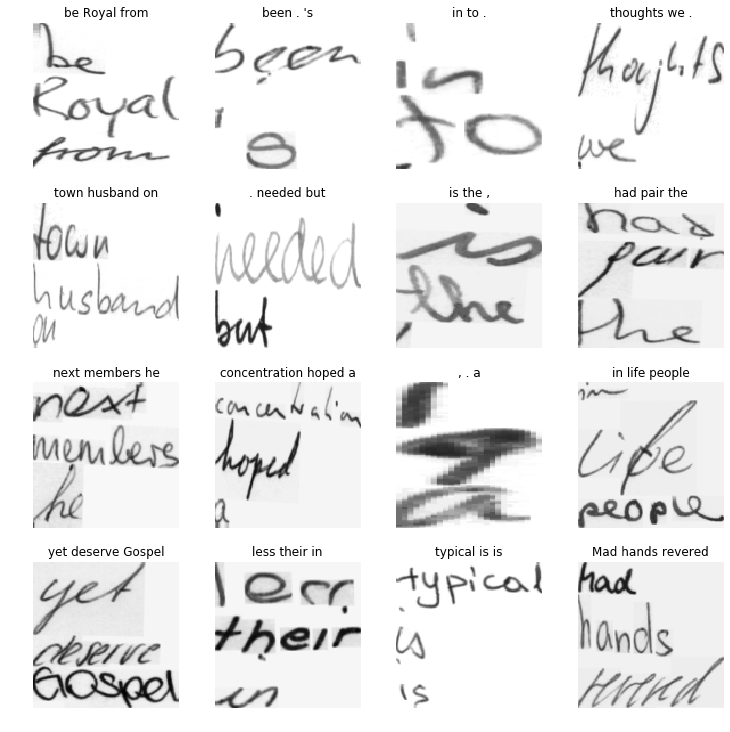

In [193]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [17]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

In [ ]:
def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 4, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)
    
    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

# Hybrid Arch

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, p=(2,2)):
        super().__init__()
        self.p = p
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni*p[0]*p[1], nh, 3, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
    
    def tile(self, x):
        bs, nf, h, w = x.size()   # Note: different order than ReNet tile!!!
        p_height = self.p[0]
        p_width  = self.p[1]

        assert h % p_height == 0
        assert w % p_width  == 0

        new_height = int(h / p_height)
        new_width  = int(w / p_width)

        x = x.view(bs, nf, new_height, p_height, new_width, p_width)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(bs, nf * p_height * p_width, new_height, new_width)
        return x

    def forward(self, x):
        x = self.tile(x)
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x

In [12]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

In [ ]:
class Hybrid(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(4,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(2,2))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([30, 1, 16, 80])
        
        return x.squeeze(1)

In [ ]:
net = Hybrid(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip = 10.
learn.metrics = [char_error_rate]

# Custom Arch

In [12]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, h = self.hrnn(x)
        else:
            x, h = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x, h

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x, _ = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x, _ = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        # 16x16x256
        self.conv0 = nn.Conv2d(256, 16, 1)   # 1x1 conv to reduce num filters
           
        self.block1 = ReNetBlock(16, nh, p=(1,1))
        self.block2 = ReNetBlock(32, nh, p=(1,1))
        self.block3 = ReNetBlock(64, nh, p=(1,1))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(1,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([bs, 4, 16, vs])
        
        return x

In [ ]:
decoder = Decoder(100, len(itos))
net = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=decoder)
opt_fn = partial(optim.Adam), betas=(0.7, 0.99)
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss

# Seq2seq (translation)

In [66]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):  
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
        
    #targ = target.permute(1,0).contiguous().view(-1)
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [103]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = ConvnetBuilder(f, embed_size, True, True).model
#         #self.enc_emb = nn.Embedding(vocab_size, embed_size)
#         self.enc_rnn = nn.GRU(embed_size, hidden_size, num_layers)
#         self.enc_linear = nn.Linear(hidden_size, embed_size)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        #self.attn = nn.Linear(hidden_size, hidden_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.dec_emb.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.weight.data = self.dec_emb.weight.data  #weight tying??
        #self.dec_linear.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.bias.data.fill_(0)
        
    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)
#         h = self.initHidden(bs)                      #([1, 30, 512])
#         enc = self.encoder(inp).unsqueeze(0)         #([1, 30, 256])
#         #emb = self.enc_emb(h)                    
#         enc_out, h = self.enc_rnn(enc, h)            #=> ([1, 30, 256]), ([1, 30, 512])
#         h = self.enc_linear(enc_out)                 #=> ([1, 30, 256])
        enc = self.encoder(inp)         #([30, 256])

        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.seq_len):
            h = torch.stack((enc,enc))  # numlayers = 2
            emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
            outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            outp = self.dec_linear(outp[0])           # linear layer => ([125, 17571])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([125])
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.num_layers, bs, self.hidden_size))

In [104]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(256, 512, len(itos), 2, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [105]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss                               
    0      224.711954 67.815809 


[67.8158088684082]

## Attention

In [15]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = ConvnetBuilder(f, embed_size, True, True).model
        #self.enc_emb = nn.Embedding(vocab_size, embed_size)
        self.enc_rnn = nn.GRU(embed_size, hidden_size, num_layers)
        self.enc_linear = nn.Linear(hidden_size, embed_size)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        #self.attn = nn.Linear(hidden_size, hidden_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        self.init_weights()
        
        # setting up Attention Layers
        self.W1 = rand_p(nh, em_sz_dec)  #=> ([256, 300])
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec) 
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec) #=> ([556, 300])
        self.V = rand_p(em_sz_dec)  #=> ([300])


    def init_weights(self):
        self.dec_emb.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.weight.data = self.dec_emb.weight.data  #weight tying??
        #self.dec_linear.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.bias.data.fill_(0)
        
    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)
        h = self.initHidden(bs)                      #([1, 30, 512])
        enc = self.encoder(inp).unsqueeze(0)         #([1, 30, 256])
        #emb = self.enc_emb(h)                    
        enc_out, h = self.enc_rnn(enc, h)            #=> ([1, 30, 256]), ([1, 30, 512])
        h = self.enc_linear(enc_out)                 #=> ([1, 30, 256])

        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())          #=> ([30, 256])
        res,attns = [],[]
        
        w1e = enc_out @ self.W1  #=> ([30, 125, 300])

        for i in range(self.seq_len):
            # take current hidden state of decoder and put it into a linear layer
            w2h = self.l2(h[-1])  #=> ([125, 300])
            # non-linear activation
            u = F.tanh(w1e + w2h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([30, 125, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * enc_out).sum(0) #=> ([125, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)

#             emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
#             outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 125, 300]),  ([2, 125, 300])
            outp = self.dec_linear(outp[0])           # linear layer => ([125, 17571])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([125])
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.num_layers, bs, self.hidden_size))

## Review

In [106]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

In [107]:
seq2seq_loss(preds, y)

tensor(66.1383, grad_fn=<DivBackward0>)

In [108]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [109]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


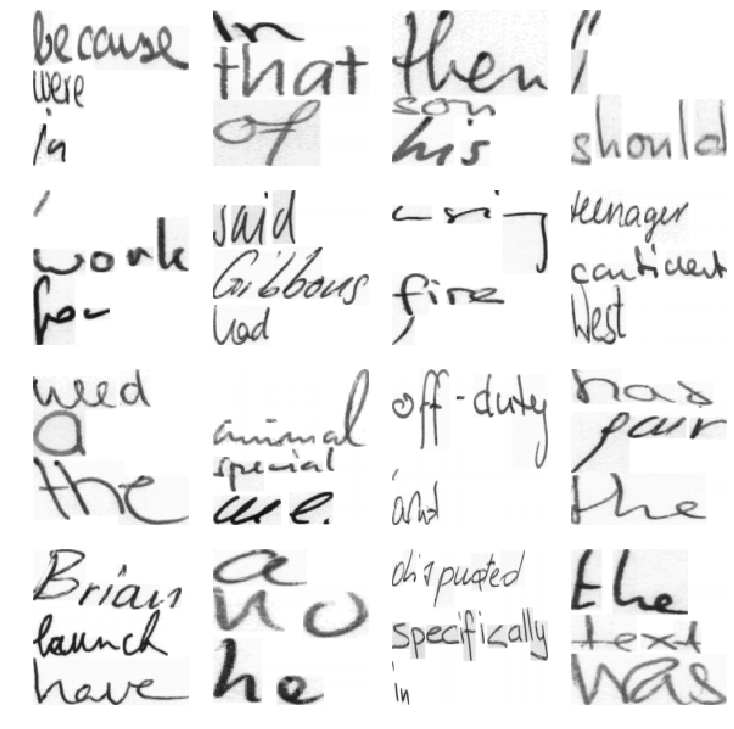

In [110]:
im = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[:,i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(im[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

# Show, Attend, Tell
https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        vggnet = torchvision.models.vgg19(pretrained=True)
        modules = list(vggnet.children())[:-1]
        self.vggnet = nn.Sequential(*modules)
        self.linear = nn.Linear(vggnet.classifier[6].in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.2)
        self.linear.bias.data.fill_(0)

    def forward(self, images):
        features = self.vggnet(images)
        features = Variable(features.data)
        print (features)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class AttnDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self):
        return cuda_variable(torch.zeros(self.num_layers, 1, self.hidden_size))

    def forward(self, captions, last_hidden, encoder_hiddens, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((last_hidden.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        rnn_output = self.linear(hiddens[0])
        print (rnn_output)

        attn_weights = self._get_att_weight(rnn_output.squeeze(0), encoder_hiddens)
        context = attn_weights.bmm(encoder_hiddens.transpose(0,1))

        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = self.out(torch.cat((rnn_output, context), 1))

        return output

    def _get_att_weight(self, hidden, encoder_hiddens):
        seq_len = len(encoder_hiddens)

        # Create variable to store attention energies
        attn_scores = cuda_variable(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(seq_len):
            attn_scores[i] = self.get_att_score(hidden, encoder_hiddens[i])

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)


    def get_att_score(self, hidden, encoder_hidden):
        score = self.attn(encoder_hidden)
        return torch.dot(hidden.view(-1), score.view(-1))


def cuda_variable(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

In [ ]:
def main(args):
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224,
                              0.225))
    ])

    data_loader = get_loader(args.image_dir, args.caption_path, vocab, transform, 128,
                             shuffle=True, num_workers=2)

    encoder = EncoderCNN(256)
    decoder = AttnDecoderRNN(256, 512, len(vocab), 1)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    total_step = len(data_loader)
    decoder_hidden = decoder.init_hidden()

    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):

            images = cuda_variable(images, volatile=True)
            captions = cuda_variable(captions)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            decoder.zero_grad()
            encoder.zero_grad()
            features = encoder(images)

            outputs = decoder(captions, decoder_hidden, features, lengths)
            # outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Combo

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.max_seq_length = max_seq_length

        *self.attn = nn.Linear(hidden_size, hidden_size)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        #return outputs

        *attn_weights = self.get_attn_weights(outputs.squeeze(0), features)
        *context = attn_weights.bmm(features.transpose(0,1))

        *result = self.out(torch.cat((outputs.squeeze(0), context.squeeze(1)), 1))
        *return result

    *def get_attn_weights(self, hidden, features):
        seq_len = len(features)

        # Create variable to store attention energies
        attn_scores = V(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(self.seq_len):
            score = self.attn(features)
            attn_scores[i] = torch.dot(hidden.view(-1), score.view(-1))

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)

    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Image Captioning
https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(args):
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, 128, shuffle=True, num_workers=2) 

    # Build the models
    encoder = EncoderCNN(256).to(device)
    decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def sample(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))